In [1]:
#Check kaggle data file
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sample_submission.csv
/kaggle/input/train.csv
/kaggle/input/test.csv


In [2]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras import initializers, optimizers

Using TensorFlow backend.


In [3]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

In [4]:
train.shape

(42000, 785)

In [5]:
test.shape

(28000, 784)

In [6]:
x_train , y_train = train.iloc[:,1:].values.astype('float32'), train.iloc[:,0].values.astype('int32')
x_test = test.values.astype('float32')

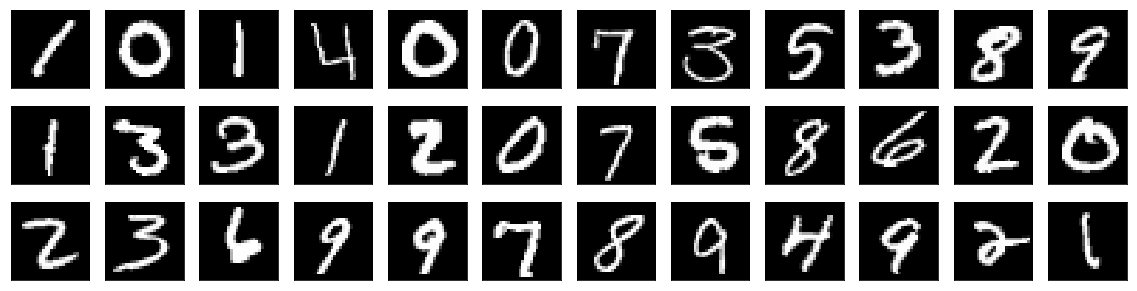

In [7]:
#Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

x_train = x_train.reshape(x_train.shape[0], 28, 28)

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap=plt.get_cmap('gray'))

In [8]:
x_train = x_train/255
x_test = x_test/255

In [9]:
#Creat cross-validation data 
import keras
from keras.utils import np_utils

vaild_len = int(len(train)/10)
# break training set into training and validation sets
(x_train, x_valid) = x_train[vaild_len:], x_train[:vaild_len]
(y_train, y_valid) = y_train[vaild_len:], y_train[:vaild_len]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (37800, 28, 28)
37800 train samples
28000 test samples
4200 validation samples


In [10]:
x_train = x_train[:,:,:,np.newaxis]
x_train.shape

(37800, 28, 28, 1)

In [11]:
x_test = x_test.reshape(x_test.shape[0], 28, 28)
x_test = x_test[:,:,:,np.newaxis]
x_test.shape

(28000, 28, 28, 1)

In [12]:
x_valid = x_valid[:,:,:,np.newaxis]
x_valid.shape

(4200, 28, 28, 1)

In [13]:
#Data Augumentation
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range =0.2, 
    height_shift_range =0.2,
    rotation_range = 15,
    zoom_range = 0.1,
    shear_range = 0.2) 

# fit augmented image generator on data
datagen_train.fit(x_train)

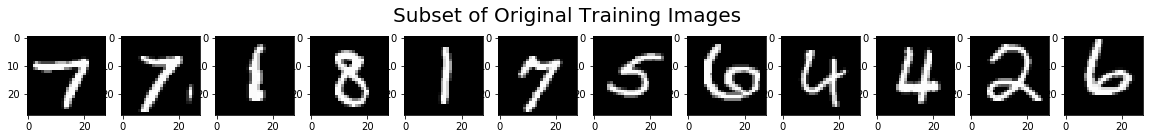

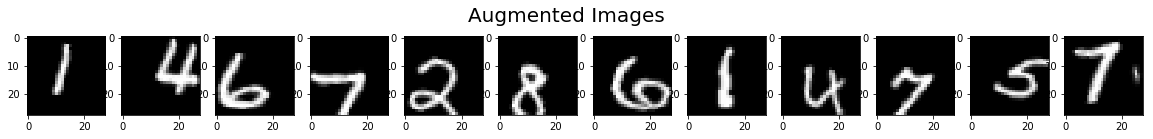

In [14]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(np.squeeze(x_train_subset[i]), cmap=plt.get_cmap('gray'))
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(np.squeeze(x_batch[i]), cmap=plt.get_cmap('gray'))
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [15]:
#Define residual layer
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu',
                 batch_normalization=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    x = conv(x)
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x

In [16]:
#simplified ResNetV1
def resnet_v1(input_shape):
    
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    
    num_filters = 16
    num_res_blocks = 2
  
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, kernel_size=5)
    # Instantiate the stack of residual units
    for res_block in range(num_res_blocks):
        strides = 1
        if res_block == 0: 
            strides = 2  # downsample
        y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
        y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
        if res_block == 0: 
        # linear projection residual shortcut connection to match
            x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, 
                             strides=strides, activation=None, batch_normalization=False)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)
    
    for res_block in range(num_res_blocks):
        strides = 1
        if res_block == 0: 
            strides = 2  # downsample
        y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
        y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
        if res_block == 0: 
        # linear projection residual shortcut connection to match
            x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, 
                             strides=strides, activation=None, batch_normalization=False)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    # v1 does not use BN after last shortcut connection-ReLU
    
    x = AveragePooling2D(pool_size=2)(x)
    y = Flatten()(x)
    outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
model = resnet_v1((28,28,1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 16)   416         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 28, 28, 16)   64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 28, 28, 16)   0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

In [18]:
# compile the model
#Use Adam first
adam = optimizers.adam(lr=0.002)
model.compile(loss='categorical_crossentropy', optimizer = adam, 
                  metrics=['accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint   

batch_size = 64
epochs = 100

# train the model
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.5,patience=3, verbose=1, mode='max',min_lr=1e-5)
history = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2,
                    validation_data=(x_valid, y_valid),
                    validation_steps=x_valid.shape[0] // batch_size,
                    callbacks=[lr_reducer])

Epoch 1/100
 - 34s - loss: 0.5292 - acc: 0.8434 - val_loss: 0.1396 - val_acc: 0.9683
Epoch 2/100
 - 23s - loss: 0.1724 - acc: 0.9585 - val_loss: 0.1778 - val_acc: 0.9524
Epoch 3/100
 - 24s - loss: 0.1416 - acc: 0.9673 - val_loss: 0.1950 - val_acc: 0.9524
Epoch 4/100
 - 23s - loss: 0.1249 - acc: 0.9742 - val_loss: 0.2007 - val_acc: 0.9569

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 5/100
 - 23s - loss: 0.0986 - acc: 0.9811 - val_loss: 0.0876 - val_acc: 0.9840
Epoch 6/100
 - 23s - loss: 0.0941 - acc: 0.9830 - val_loss: 0.0885 - val_acc: 0.9836
Epoch 7/100
 - 23s - loss: 0.0894 - acc: 0.9839 - val_loss: 0.0805 - val_acc: 0.9879
Epoch 8/100
 - 29s - loss: 0.0892 - acc: 0.9839 - val_loss: 0.1231 - val_acc: 0.9736
Epoch 9/100
 - 26s - loss: 0.0869 - acc: 0.9840 - val_loss: 0.0890 - val_acc: 0.9826
Epoch 10/100
 - 26s - loss: 0.0845 - acc: 0.9845 - val_loss: 0.1237 - val_acc: 0.9707

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00050000

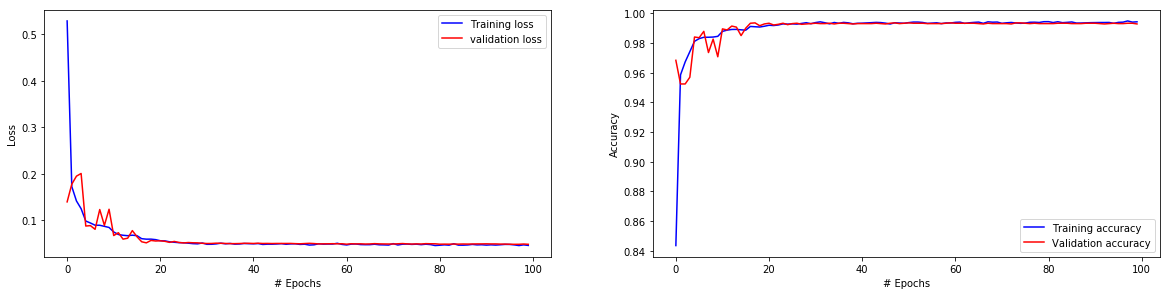

In [20]:
# Plot the loss and accuracy curves for training and validation 

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (20,10))
plt.subplot(221)
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(222)
plt.plot(history.history['acc'], color='b', label="Training accuracy")
plt.plot(history.history['val_acc'], color='r',label="Validation accuracy")
plt.legend(loc='best')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')

plt.show()

In [21]:
#Further Training with SGD and lower learning rate
batch_size = 64
epochs = 100

SGD = optimizers.SGD(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer = SGD, metrics=['accuracy'])
lr_reducer_SGD = ReduceLROnPlateau(monitor='val_acc',factor=0.75, patience=5, verbose=1,
                               mode='max',min_lr=1e-6)
history = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2,
                    validation_data=(x_valid, y_valid),
                    validation_steps=x_valid.shape[0] // batch_size,
                    callbacks=[lr_reducer_SGD])

Epoch 1/100
 - 15s - loss: 0.0479 - acc: 0.9935 - val_loss: 0.0486 - val_acc: 0.9931
Epoch 2/100
 - 13s - loss: 0.0474 - acc: 0.9942 - val_loss: 0.0484 - val_acc: 0.9931
Epoch 3/100
 - 13s - loss: 0.0461 - acc: 0.9941 - val_loss: 0.0486 - val_acc: 0.9931
Epoch 4/100
 - 14s - loss: 0.0469 - acc: 0.9936 - val_loss: 0.0485 - val_acc: 0.9933
Epoch 5/100
 - 13s - loss: 0.0461 - acc: 0.9944 - val_loss: 0.0486 - val_acc: 0.9931
Epoch 6/100
 - 13s - loss: 0.0464 - acc: 0.9939 - val_loss: 0.0485 - val_acc: 0.9931
Epoch 7/100
 - 13s - loss: 0.0468 - acc: 0.9942 - val_loss: 0.0486 - val_acc: 0.9931
Epoch 8/100
 - 13s - loss: 0.0462 - acc: 0.9943 - val_loss: 0.0486 - val_acc: 0.9931
Epoch 9/100
 - 13s - loss: 0.0464 - acc: 0.9942 - val_loss: 0.0485 - val_acc: 0.9933

Epoch 00009: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-05.
Epoch 10/100
 - 14s - loss: 0.0457 - acc: 0.9946 - val_loss: 0.0483 - val_acc: 0.9931
Epoch 11/100
 - 13s - loss: 0.0466 - acc: 0.9939 - val_loss: 0.0486 

In [22]:
predictions = model.predict(x_test, verbose=0)
predictions = np.argmax(predictions,axis =1)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("CNN_5.csv", index=False, header=True)